In [1]:
import pandas as pd
import yaml
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from modeling import update_config

In [2]:
rusher_stat_cols =[
 'carries_roll',
 'rushing_yards_roll',
 #'rushing_tds_roll',
 #'rushing_first_downs_roll',
 #'receiving_yards_roll',
 #'receiving_tds_roll',
 #'fantasy_points_ppr_roll',
 'yards_per_carry_roll']

In [3]:
team = pd.read_csv('data/agg/team_stats.csv', index_col=0)
opp = pd.read_csv('data/agg/opp_stats.csv', index_col=0)
team_stat_cols = [
 'completions_team_roll',
 'attempts_team_roll',
 'carries_team_roll',
 'passing_yards_team_roll',
 'rushing_yards_team_roll',
 'pass_pct_team_roll',
 'completions_opp_roll',
 'attempts_opp_roll',
 'carries_opp_roll',
 'passing_yards_opp_roll',
 'rushing_yards_opp_roll',
 'pass_pct_opp_roll']

In [4]:
pbp = pd.read_parquet("data/pbp.parquet")
pbp = pbp.merge(team, left_on=['posteam','season','week'], right_on=['recent_team','season','week']).drop('recent_team',axis=1)
pbp = pbp.merge(opp, left_on=['defteam','season','week'], right_on=['opponent_team','season','week']).drop('opponent_team',axis=1)

rushes = pbp.loc[(pbp.play_type=='run') & (~pbp.yards_gained.isna())].copy(
    deep=True
)


In [5]:
rusher_stats = pd.read_parquet('data/agg/player_weekly_agg.parquet')[['season', 'team_name', 'week', 'game_type',  'gsis_id', 
       'position', 'depth_position', 'full_name', 'dense_depth',
 'carries_roll',
 'rushing_yards_roll',
 'rushing_tds_roll',
 'rushing_first_downs_roll',
 'receptions_roll',
 'targets_roll',
 'receiving_yards_roll',
 'receiving_tds_roll',
 'fantasy_points_roll',
 'fantasy_points_ppr_roll',
 'yards_per_carry_roll']]
rushes = rushes.merge(
    rusher_stats,
    left_on=["posteam", "season", "week", "rusher_player_id"],
    right_on=["team_name", "season", "week", 'gsis_id'],
)
rushes[[ 'carries_roll',
 'rushing_yards_roll',
 'fantasy_points_ppr_roll', 'yards_per_carry_roll', 'rushing_tds_roll','rushing_first_downs_roll']] = rushes[[ 'carries_roll',
 'rushing_yards_roll',
 'fantasy_points_ppr_roll',
 'yards_per_carry_roll','rushing_tds_roll','rushing_first_downs_roll']].fillna(0)

rushes = rushes.loc[~rushes.down.isna()].copy(deep=True)

In [6]:
game_context_cols = [
    "yardline_100",
    "down",
    "goal_to_go",
    "ydstogo",
    "posteam_score",
    "defteam_score",
    "score_differential",
    #'quarter_seconds_remaining',
    #'half_seconds_remaining',
    'game_seconds_remaining',
    "wind",
    "temp",
    'spread_line',
    'total_line'
]
team_rush_cols = [
 'rushing_yards_team_roll',
 'rushing_yards_opp_roll']

In [7]:
rush_yards_cols = game_context_cols + rusher_stat_cols + team_rush_cols

In [8]:
X = rushes[rush_yards_cols]
y = rushes['yards_gained'].astype(int).values
obs = len(X)
num_feats = len(rush_yards_cols)


In [9]:
from quantile_forest import RandomForestQuantileRegressor

In [57]:
from sklearn_quantile import RandomForestQuantileRegressor

In [58]:
train_data = rushes.loc[rushes.season != 2024].copy()
X = train_data[rush_yards_cols]
y = train_data['yards_gained']
xt = rushes.loc[rushes.season == 2024, rush_yards_cols].copy()
yt = rushes.loc[rushes.season == 2024, 'yards_gained'].copy()

In [59]:
rush_yards_cols

monotonic = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 1, 1, 1]
[(a,b) for a,b in zip(rush_yards_cols, monotonic)]

[('yardline_100', 0),
 ('down', 0),
 ('goal_to_go', 0),
 ('ydstogo', 0),
 ('posteam_score', 0),
 ('defteam_score', 0),
 ('score_differential', 0),
 ('game_seconds_remaining', 0),
 ('wind', 0),
 ('temp', 0),
 ('spread_line', -1),
 ('total_line', 0),
 ('carries_roll', 0),
 ('rushing_yards_roll', 0),
 ('yards_per_carry_roll', 1),
 ('rushing_yards_team_roll', 1),
 ('rushing_yards_opp_roll', 1)]

In [60]:
qrf = RandomForestQuantileRegressor(n_jobs=16, min_samples_leaf=32, max_depth=8, max_samples=0.25)
qrf.fit(X, y)

RandomForestQuantileRegressor(max_depth=8, max_samples=0.25,
                              min_samples_leaf=32,
                              monotonic_cst=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1,
                                             0, 0, 0, 1, 1, 1],
                              n_jobs=16)

In [61]:
qrf

RandomForestQuantileRegressor(max_depth=8, max_samples=0.25,
                              min_samples_leaf=32,
                              monotonic_cst=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1,
                                             0, 0, 0, 1, 1, 1],
                              n_jobs=16)

In [62]:
import joblib
joblib.dump(qrf, "models/rush_yards_qrf.joblib")

['models/rush_yards_qrf.joblib']

In [79]:
q = list(np.arange(0,1,0.01))
qrf.q = sorted(q)
qrf.predict(xt.loc[xt.yardline_100 == 3])

array([[ -9., -10., -10., ..., -10., -10., -10.],
       [ -5.,  -5.,  -5., ...,  -5.,  -5.,  -4.],
       [ -4.,  -4.,  -4., ...,  -3.,  -4.,  -3.],
       ...,
       [  3.,   3.,   3., ...,   3.,   3.,   3.],
       [  4.,   3.,   3., ...,   4.,   4.,   3.],
       [  4.,   4.,   4., ...,   4.,   4.,   4.]], dtype=float32)

In [108]:
rusher_stat_cols

['carries_roll', 'rushing_yards_roll', 'yards_per_carry_roll']

In [125]:
saq = rushes.loc[(rushes.rusher_player_name=='S.Barkley')
                & (rushes.season==2024)].tail(1)[rusher_stat_cols].copy()
saq.values[0]

array([ 20.84219476, 117.4759491 ,   5.6364481 ])

In [126]:
x_samp = xt.loc[xt.yardline_100 == ydl].copy()
x_samp[rusher_stat_cols] = saq.values[0]
display(x_samp)

,yardline_100,down,goal_to_go,ydstogo,posteam_score,defteam_score,score_differential,game_seconds_remaining,wind,temp,spread_line,total_line,carries_roll,rushing_yards_roll,yards_per_carry_roll,rushing_yards_team_roll,rushing_yards_opp_roll
203154,2.0,2.0,1,2.0,10.0,33.0,-23.0,33.0,17.0,69.0,-2.5,42.0,20.842195,117.475949,5.636448,0.695142,1.114959
203247,2.0,2.0,0,1.0,24.0,26.0,-2.0,1172.0,10.0,55.0,-2.0,49.5,20.842195,117.475949,5.636448,1.102023,0.912123
203321,2.0,2.0,1,2.0,22.0,20.0,2.0,382.0,5.0,58.0,-3.0,49.0,20.842195,117.475949,5.636448,0.727029,1.143024
203416,2.0,1.0,1,2.0,3.0,17.0,-14.0,1116.0,5.0,58.0,5.0,54.0,20.842195,117.475949,5.636448,1.048452,0.716942
203604,2.0,1.0,1,2.0,6.0,7.0,-1.0,2220.0,10.0,76.0,-3.5,43.0,20.842195,117.475949,5.636448,1.257632,0.950394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211957,2.0,2.0,1,2.0,17.0,10.0,7.0,986.0,5.0,47.0,-3.0,39.5,20.842195,117.475949,5.636448,1.011463,1.202982
212094,2.0,2.0,0,1.0,0.0,3.0,-3.0,2043.0,13.0,36.0,3.5,36.5,20.842195,117.475949,5.636448,0.621163,0.824100
212119,2.0,2.0,1,2.0,10.0,6.0,4.0,779.0,13.0,36.0,3.5,36.5,20.842195,117.475949,5.636448,0.621163,0.824100
212120,2.0,4.0,1,2.0,10.0,6.0,4.0,743.0,13.0,36.0,3.5,36.5,20.842195,117.475949,5.636448,0.621163,0.824100


In [151]:
feats = np.round(1000 * qrf.feature_importances_)
for x in zip(rush_yards_cols, feats):
    print(x)

('yardline_100', 419.0)
('down', 47.0)
('goal_to_go', 0.0)
('ydstogo', 66.0)
('posteam_score', 19.0)
('defteam_score', 19.0)
('score_differential', 40.0)
('game_seconds_remaining', 57.0)
('wind', 15.0)
('temp', 22.0)
('spread_line', 2.0)
('total_line', 27.0)
('carries_roll', 54.0)
('rushing_yards_roll', 30.0)
('yards_per_carry_roll', 33.0)
('rushing_yards_team_roll', 73.0)
('rushing_yards_opp_roll', 76.0)


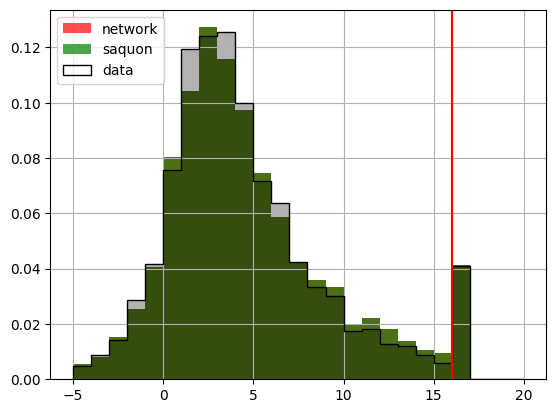

data: 4.043, network:4.255, saquon:4.255


: 

In [ ]:
ydl = 16
q = list(np.random.random(10000))
qrf.q = sorted(q)
x_samp = xt.loc[xt.yardline_100 == ydl].copy()
saq_x = x_samp.copy()
x_samp[['rushing_yards_team_roll', 'rushing_yards_opp_roll']] = [155, 154]
sample = qrf.predict(x_samp).reshape(-1)
sample = sample.clip(-10, ydl)

bins = range(-5, ydl + 5)
plt.hist(sample, density=True, bins=bins, label="network", color='r',alpha=0.7)

saq_x[rusher_stat_cols] = saq.values[0]
sample_saq = qrf.predict(saq_x).reshape(-1)
sample_saq = sample.clip(-10, ydl)

bins = range(-5, ydl + 5)
plt.hist(sample_saq, density=True, bins=bins, label="saquon", color='g',alpha=0.7)


testy = train_data.loc[train_data.yardline_100 == ydl, "yards_gained"].copy()
testy.hist(
    density=True, alpha=1, bins=bins, label="data", histtype="step", color="black"
)
testy.hist(density=True, alpha=0.3, bins=bins, color="black")
plt.axvline(ydl,color='r')
plt.legend()
plt.show()
print(f"data: {testy.mean():.4}, network:{sample.mean():.4}, saquon:{sample_saq.mean():.4}")

In [30]:
train_data.loc[train_data.game_seconds_remaining < 50]['yards_gained'].mean()

4.6289425

In [17]:
rushes[['yardline_100','down','yards_gained']].groupby(['yardline_100','down'])['yards_gained'].quantile(0.9)

yardline_100  down
1.0           1.0      1.0
              2.0      1.0
              3.0      1.0
              4.0      1.0
2.0           1.0      2.0
                      ... 
98.0          2.0      7.6
              3.0      9.0
99.0          1.0      5.0
              2.0      8.0
              3.0     10.8
Name: yards_gained, Length: 384, dtype: float64

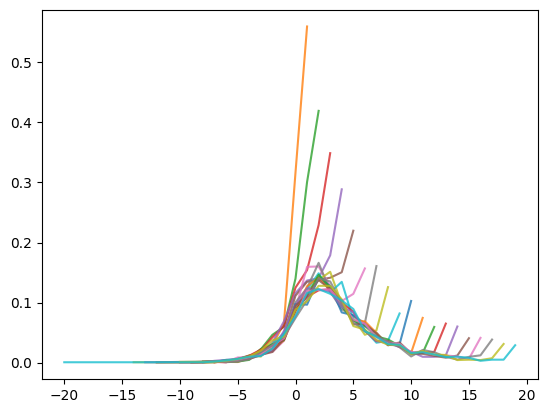

In [18]:
for i in range(0,20):
    a = rushes.loc[rushes.yardline_100==i, 'yards_gained'].value_counts(normalize=True).reset_index().sort_values(by='yards_gained')
    plt.plot(a['yards_gained'],a['proportion'], alpha=0.8)

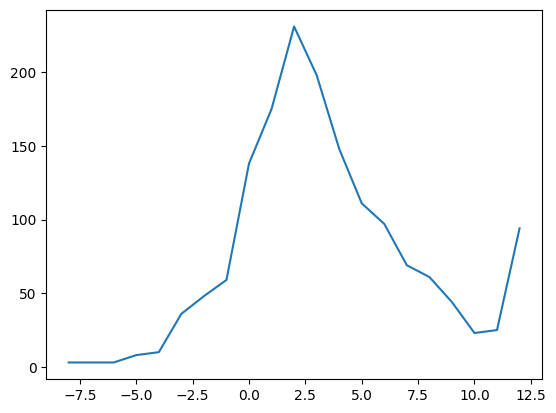

In [19]:
a = rushes.loc[rushes.yardline_100==12, 'yards_gained'].value_counts().reset_index().sort_values(by='yards_gained')
plt.plot(a['yards_gained'],a['count'])


In [ ]:
def sample_custom(ydl, num_samples):
    data = (
        rushes.loc[rushes.yardline_100 == ydl].sample(num_samples, replace=True).copy()
    )
    x_ = df_to_X(data)
    o = rush_yards_model(x_.to("cuda"))
    yard_probs = F.softmax(o, dim=1).detach().to("cpu")
    return yard_probs


ydl = 24

print(ydl)
yard_probs = sample_custom(ydl, 10000)
yard_probs = yard_probs.mean(dim=0)


sample = torch.multinomial(yard_probs, 30000, replacement=True)
bins = range(0, ydl + 15)
plt.hist(sample, density=True, bins=bins, label="network")


testy = rushes.loc[rushes.yardline_100 == ydl, "end_yardline"].copy()
testy.hist(
    density=True, alpha=1, bins=bins, label="data", histtype="step", color="black"
)
testy.hist(density=True, alpha=0.3, bins=bins, color="black")
plt.axvline(ydl,color='r')
plt.legend()
plt.show()
print(f"data: {ydl -testy.mean():.4}, network:{ydl - sample.double().mean():.4}")

<Axes: >

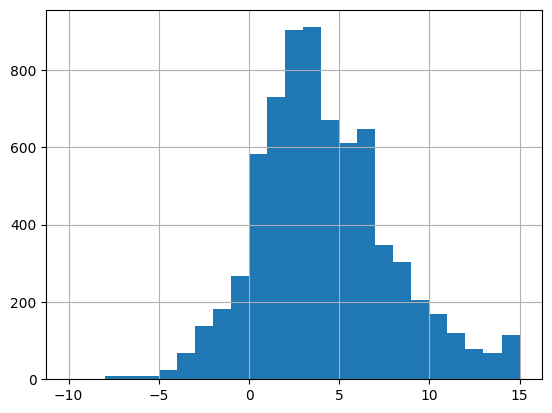

In [23]:
rushes.loc[(rushes.ydstogo==7)]['yards_gained'].hist(bins=range(-10, 16))
